### Data preprocessing

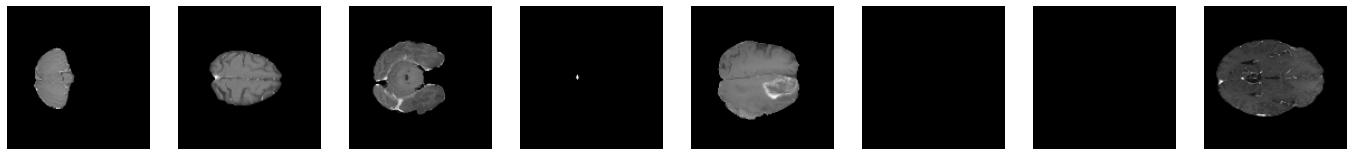

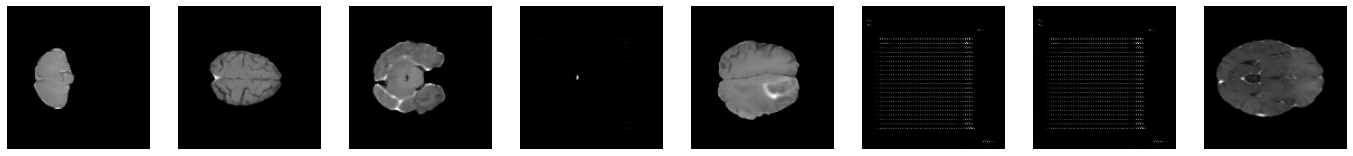

In [13]:
rand_idx = np.random.randint(0, 32000, size=(8,))
pos = slice_positions[rand_idx]
with torch.no_grad():
    originals = np.concatenate([flair[rand_idx], t1ce[rand_idx]], axis=1)
    originals = torch.from_numpy(originals).to(device, dtype=torch.float32)
    reconstructed, z_i, qloss = ae(originals, pos)
    reconstructed = torch.tanh(reconstructed)
    for c, vec in enumerate([originals, reconstructed]):
        plt.figure(figsize=(24, 8))
        for i in range(8):
            plt.subplot(1, 8, i + 1)
            plt.imshow(vec[i, 1, :, :].detach().cpu().numpy(), cmap='gray')
            plt.axis('off')
        plt.show()

In [8]:
from models.vector_quantized_autoencoder import VQAutoencoder
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# constants
IN_CHANNELS = 2
OUT_CHANNELS = IN_CHANNELS
BATCH_SIZE = 8
AE_EPOCHS = 2000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Imported')
print('Used device:', device)

ae = VQAutoencoder(
    IN_CHANNELS, 
    OUT_CHANNELS, 
    n_embed=8192, 
    embed_dim=4, 
    z_channels=8, 
    z_double=False, 
    pemb_dim=128,
    num_channels=128,
    channels_mult=[1, 2, 4, 4], 
    attn=[False, False, False, True],
    num_res_blocks=2
).to(device)

x = torch.randn(2, 2, 128, 128).to(device)
pos = torch.randint(0, 64, size=(2,), dtype=torch.long, device=device)



Imported
Used device: cuda


In [9]:
x, z_i, qloss, indices = ae(x, pos, return_indices=True)

In [21]:
import torch
a, b = torch.randn(2, 4, 4)
torch.cosine_similarity(a, b)

TypeError: cosine_similarity() got an unexpected keyword argument 'reduction'